In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 120)
%matplotlib inline


In [6]:
customers_path = "/content/eximbank_customers_sample.csv"
calls_path = "/content/eximbank_telesales_calls_sample.csv"
customers_raw = pd.read_csv(customers_path)
calls_raw = pd.read_csv(calls_path)

print(customers_raw.shape)
print(calls_raw.shape)
display(customers_raw.head())
display(calls_raw.head())


(210, 12)
(283, 10)


,customer_id,full_name,phone_raw,address_raw,city,province,gender,dob,segment,branch,source_campaign,created_date
0,C0001,Tran Thi Tu,NaN,"7 Nguyen Thi Minh Khai, P.2",Hai Phong,Can Tho,Male,1985-05-06,VIP,Can Tho - Ninh Kieu,Event,2024-04-12
1,C0002,nguyen ngoc khanh,+84922713332,"138 Le Loi, P.7",Ho Chi Minh,Hai Phong,Female,2019-09-23,SME,Can Tho - Ninh Kieu,Branch referral,2024-09-27
2,C0003,tran thi trang,0798834813,"156 Tran Hung Dao, P.10",Ha Noi,Ha Noi,Female,2015-09-30,VIP,Ha Noi - Hoan Kiem,Partnership,2024-03-12
3,C0004,Pham Minh An,+84888409572,"227 Pham Van Dong, P.2",Da Nang,Ha Noi,Male,1998-09-09,SME,Can Tho - Ninh Kieu,Old customer list,2024-01-21
4,C0005,Dang Minh Trang,NaN,"120 Nguyen Thi Minh Khai, P.5",Hai Phong,TP.HCM,Male,1984-04-07,SME,Ha Noi - Hoan Kiem,Online form,2024-05-01


,call_id,customer_id,call_date,call_time,agent_id,call_duration_sec,call_result,sentiment,product_pitched,notes
0,CL00001,C0003,2024-09-02,14:28,AG07,46,Busy,NaN,Personal Loan,NaN
1,CL00002,C0003,2024-01-26,10:49,AG05,427,Registered Product,Negative,Savings Account,Customer agreed to open product.
2,CL00003,C0004,2024-11-08,11:44,AG01,39,Connected - Not Interested,Neutral,Savings Account,Customer refused politely.
3,CL00004,C0004,2024-09-20,19:50,AG07,490,Registered Product,Positive,Credit Card,Customer agreed to open product.
4,CL00005,C0004,2024-04-01,09:01,AG07,36,Busy,NaN,Term Deposit,NaN


In [7]:
print("🔎 Thống kê mô tả một số cột số của calls_raw:")
display(calls_raw.describe())

print("\n🔎 Thiếu dữ liệu trong customers_raw:")
display(customers_raw.isnull().sum())

print("\n🔎 Thiếu dữ liệu trong calls_raw:")
display(calls_raw.isnull().sum())

print("\n🔎 Số lượng customer_id trùng (dạng thô):")
print(customers_raw["customer_id"].duplicated().sum())

print("\n🔎 Giá trị duy nhất của 'call_result':")
print(calls_raw["call_result"].value_counts())


🔎 Thống kê mô tả một số cột số của calls_raw:


,call_duration_sec
count,283.000000
mean,142.922261
std,171.042883
min,5.000000
25%,30.000000
50%,48.000000
75%,246.000000
max,595.000000



🔎 Thiếu dữ liệu trong customers_raw:


,0
customer_id,0
full_name,0
phone_raw,45
address_raw,0
city,0
province,0
gender,0
dob,0
segment,0
branch,0



🔎 Thiếu dữ liệu trong calls_raw:


,0
call_id,0
customer_id,0
call_date,0
call_time,0
agent_id,0
call_duration_sec,0
call_result,0
sentiment,162
product_pitched,0
notes,121



🔎 Số lượng customer_id trùng (dạng thô):
0

🔎 Giá trị duy nhất của 'call_result':
call_result
Registered Product            45
No Answer                     45
Busy                          43
Connected - Not Interested    43
Wrong Number                  37
Call Back Later               37
Connected - Interested        33
Name: count, dtype: int64


In [10]:
import re

def clean_full_name(name: str) -> str:
    """
    Chuẩn hóa họ tên khách hàng:
    - Chuyển về dạng Title Case (Nguyen Van A)
    - Loại bỏ khoảng trắng dư thừa ở đầu/cuối
    """
    if pd.isnull(name):
        return None
    return str(name).strip().title()


def clean_phone_number(phone: str) -> str:
    """
    Chuẩn hóa số điện thoại:
    - Giữ lại chữ số
    - Xử lý prefix +84 -> 0
    - Trả về None nếu độ dài không hợp lệ
    """
    if pd.isnull(phone):
        return None

    # Loại hết ký tự không phải số
    digits = re.sub(r"\D", "", str(phone))

    # Nếu bắt đầu bằng '84' và đủ dài, convert sang '0...'
    if digits.startswith("84") and len(digits) >= 10:
        digits = "0" + digits[2:]

    if len(digits) < 9 or len(digits) > 11:
        return None

    return digits


In [11]:
customers = customers_raw.copy()

# 1. Chuẩn hóa họ tên
customers["full_name_clean"] = customers["full_name"].apply(clean_full_name)

# 2. Chuẩn hóa số điện thoại
customers["phone_clean"] = customers["phone_raw"].apply(clean_phone_number)

# 3. Loại bỏ trùng lặp theo customer_id (giữ bản ghi đầu tiên)
before_dedup = customers.shape[0]
customers = customers.drop_duplicates(subset="customer_id", keep="first")
after_dedup = customers.shape[0]

print(f"🔁 Số dòng trước khi remove duplicate: {before_dedup}")
print(f"✅ Số dòng sau khi remove duplicate: {after_dedup}")
display(customers[[
    "customer_id", "full_name", "full_name_clean",
    "phone_raw", "phone_clean", "address_raw", "city", "province"
]].head(10))

print("\n🔎 Kiểm tra missing sau làm sạch:")
display(customers[["full_name_clean", "phone_clean"]].isnull().sum())


🔁 Số dòng trước khi remove duplicate: 210
✅ Số dòng sau khi remove duplicate: 210


,customer_id,full_name,full_name_clean,phone_raw,phone_clean,address_raw,city,province
0,C0001,Tran Thi Tu,Tran Thi Tu,NaN,None,"7 Nguyen Thi Minh Khai, P.2",Hai Phong,Can Tho
1,C0002,nguyen ngoc khanh,Nguyen Ngoc Khanh,+84922713332,0922713332,"138 Le Loi, P.7",Ho Chi Minh,Hai Phong
2,C0003,tran thi trang,Tran Thi Trang,0798834813,0798834813,"156 Tran Hung Dao, P.10",Ha Noi,Ha Noi
3,C0004,Pham Minh An,Pham Minh An,+84888409572,0888409572,"227 Pham Van Dong, P.2",Da Nang,Ha Noi
4,C0005,Dang Minh Trang,Dang Minh Trang,NaN,None,"120 Nguyen Thi Minh Khai, P.5",Hai Phong,TP.HCM
5,C0006,hoang quang nam,Hoang Quang Nam,NaN,None,"51 Tran Hung Dao, P.5",Ha Noi,Hai Phong
6,C0007,Tran Minh Tu,Tran Minh Tu,+84308904077,0308904077,"243 Nguyen Thi Minh Khai, P.2",Da Nang,Hai Phong
7,C0008,hoang quang loan,Hoang Quang Loan,0984 200 550,0984200550,"18 Nguyen Trai, P.5",Ho Chi Minh,Hai Phong
8,C0009,Do Ngoc Phuc,Do Ngoc Phuc,0978104447,0978104447,"104 Hai Ba Trung, P.1",Ha Noi,Ha Noi
9,C0010,Le Hong Phuc,Le Hong Phuc,0980 880 650,0980880650,"43 Ly Thuong Kiet, P.7",Can Tho,Ha Noi



🔎 Kiểm tra missing sau làm sạch:


,0
full_name_clean,0
phone_clean,45


In [12]:
calls = calls_raw.copy()

# 1. Chuyển kiểu ngày
calls["call_date"] = pd.to_datetime(calls["call_date"], errors="coerce")

# 2. Tạo cột thời lượng phút từ giây
calls["call_duration_min"] = calls["call_duration_sec"] / 60

# 3. Kiểm tra nhanh
print("📌 Thống kê thời lượng cuộc gọi (phút):")
display(calls["call_duration_min"].describe())

print("\n📌 Phân bố kết quả cuộc gọi:")
display(calls["call_result"].value_counts())


📌 Thống kê thời lượng cuộc gọi (phút):


,call_duration_min
count,283.000000
mean,2.382038
std,2.850715
min,0.083333
25%,0.500000
50%,0.800000
75%,4.100000
max,9.916667



📌 Phân bố kết quả cuộc gọi:


,count
call_result,
Registered Product,45
No Answer,45
Busy,43
Connected - Not Interested,43
Wrong Number,37
Call Back Later,37
Connected - Interested,33


In [13]:
df = calls.merge(
    customers,
    on="customer_id",
    how="left",
    suffixes=("_call", "_cust")
)

print("📌 Kích thước sau merge:", df.shape)
print("\n🔍 5 dòng đầu sau khi merge:")
display(df.head())

print("\n🔎 Kiểm tra xem có cuộc gọi nào không join được khách hàng không:")
missing_customers = df["full_name_clean"].isnull().sum()
print(f"Số cuộc gọi không có thông tin khách hàng: {missing_customers}")


📌 Kích thước sau merge: (283, 24)

🔍 5 dòng đầu sau khi merge:


,call_id,customer_id,call_date,call_time,agent_id,call_duration_sec,call_result,sentiment,product_pitched,notes,call_duration_min,full_name,phone_raw,address_raw,city,province,gender,dob,segment,branch,source_campaign,created_date,full_name_clean,phone_clean
0,CL00001,C0003,2024-09-02,14:28,AG07,46,Busy,NaN,Personal Loan,NaN,0.766667,tran thi trang,0798834813,"156 Tran Hung Dao, P.10",Ha Noi,Ha Noi,Female,2015-09-30,VIP,Ha Noi - Hoan Kiem,Partnership,2024-03-12,Tran Thi Trang,0798834813
1,CL00002,C0003,2024-01-26,10:49,AG05,427,Registered Product,Negative,Savings Account,Customer agreed to open product.,7.116667,tran thi trang,0798834813,"156 Tran Hung Dao, P.10",Ha Noi,Ha Noi,Female,2015-09-30,VIP,Ha Noi - Hoan Kiem,Partnership,2024-03-12,Tran Thi Trang,0798834813
2,CL00003,C0004,2024-11-08,11:44,AG01,39,Connected - Not Interested,Neutral,Savings Account,Customer refused politely.,0.650000,Pham Minh An,+84888409572,"227 Pham Van Dong, P.2",Da Nang,Ha Noi,Male,1998-09-09,SME,Can Tho - Ninh Kieu,Old customer list,2024-01-21,Pham Minh An,0888409572
3,CL00004,C0004,2024-09-20,19:50,AG07,490,Registered Product,Positive,Credit Card,Customer agreed to open product.,8.166667,Pham Minh An,+84888409572,"227 Pham Van Dong, P.2",Da Nang,Ha Noi,Male,1998-09-09,SME,Can Tho - Ninh Kieu,Old customer list,2024-01-21,Pham Minh An,0888409572
4,CL00005,C0004,2024-04-01,09:01,AG07,36,Busy,NaN,Term Deposit,NaN,0.600000,Pham Minh An,+84888409572,"227 Pham Van Dong, P.2",Da Nang,Ha Noi,Male,1998-09-09,SME,Can Tho - Ninh Kieu,Old customer list,2024-01-21,Pham Minh An,0888409572



🔎 Kiểm tra xem có cuộc gọi nào không join được khách hàng không:
Số cuộc gọi không có thông tin khách hàng: 0


In [14]:
contact_results = ["Connected - Interested",
                   "Connected - Not Interested",
                   "Registered Product"]

total_calls = df.shape[0]

contact_calls = df[df["call_result"].isin(contact_results)].shape[0]
success_calls = df[df["call_result"] == "Registered Product"].shape[0]
wrong_number_calls = df[df["call_result"] == "Wrong Number"].shape[0]

contact_rate = contact_calls / total_calls * 100 if total_calls > 0 else 0
success_rate = success_calls / total_calls * 100 if total_calls > 0 else 0
wrong_number_rate = wrong_number_calls / total_calls * 100 if total_calls > 0 else 0

avg_duration = df["call_duration_min"].mean()

print("📊 KPI TỔNG QUAN CHIẾN DỊCH")
print(f"- Tổng số cuộc gọi: {total_calls}")
print(f"- Số cuộc gọi liên hệ được: {contact_calls} ({contact_rate:.2f}%)")
print(f"- Số cuộc gọi đăng ký sản phẩm: {success_calls} ({success_rate:.2f}%)")
print(f"- Số cuộc gọi sai số điện thoại: {wrong_number_calls} ({wrong_number_rate:.2f}%)")
print(f"- Thời lượng cuộc gọi trung bình: {avg_duration:.2f} phút")


📊 KPI TỔNG QUAN CHIẾN DỊCH
- Tổng số cuộc gọi: 283
- Số cuộc gọi liên hệ được: 121 (42.76%)
- Số cuộc gọi đăng ký sản phẩm: 45 (15.90%)
- Số cuộc gọi sai số điện thoại: 37 (13.07%)
- Thời lượng cuộc gọi trung bình: 2.38 phút


📊 KPI theo phân khúc khách hàng:


,segment,total_calls,success_calls,success_rate
0,Mass,53,9,16.981132
1,Retail,63,4,6.349206
2,SME,89,13,14.606742
3,VIP,78,19,24.358974


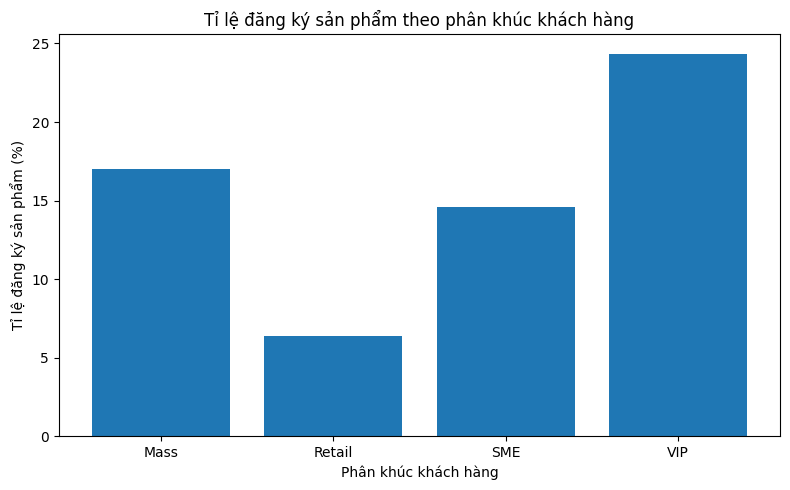

In [15]:
segment_stats = (
    df.groupby("segment")
    .agg(
        total_calls=("call_id", "count"),
        success_calls=("call_result", lambda x: (x == "Registered Product").sum())
    )
    .reset_index()
)

segment_stats["success_rate"] = (
    segment_stats["success_calls"] / segment_stats["total_calls"] * 100
)

print("📊 KPI theo phân khúc khách hàng:")
display(segment_stats)

# Vẽ biểu đồ
plt.figure(figsize=(8,5))
plt.bar(segment_stats["segment"], segment_stats["success_rate"])
plt.xlabel("Phân khúc khách hàng")
plt.ylabel("Tỉ lệ đăng ký sản phẩm (%)")
plt.title("Tỉ lệ đăng ký sản phẩm theo phân khúc khách hàng")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


📊 KPI theo chi nhánh:


,branch,total_calls,success_calls,success_rate
0,Can Tho - Ninh Kieu,63,13,20.634921
1,Da Nang - Hai Chau,58,4,6.896552
2,HCM - District 1,48,8,16.666667
3,HCM - Phu Nhuan,55,9,16.363636
4,Ha Noi - Hoan Kiem,59,11,18.644068


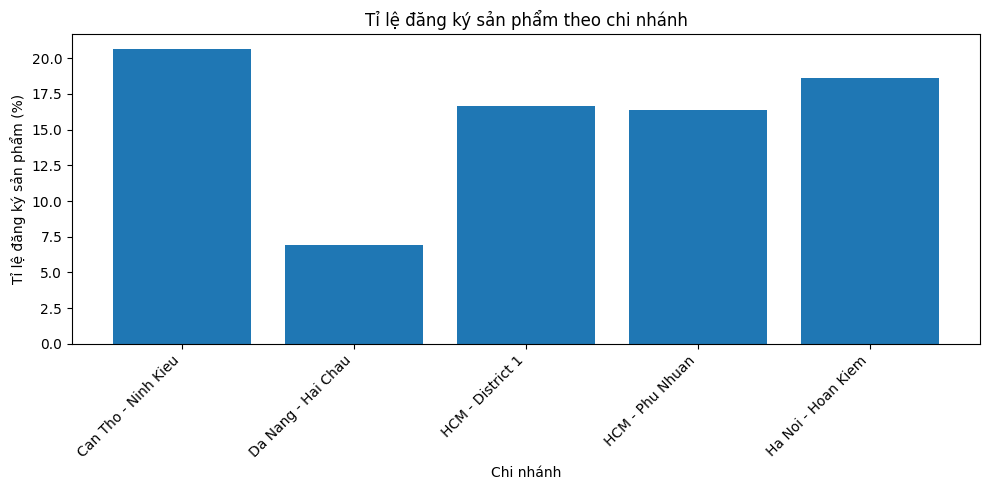

In [16]:
branch_stats = (
    df.groupby("branch")
    .agg(
        total_calls=("call_id", "count"),
        success_calls=("call_result", lambda x: (x == "Registered Product").sum())
    )
    .reset_index()
)

branch_stats["success_rate"] = (
    branch_stats["success_calls"] / branch_stats["total_calls"] * 100
)

print("📊 KPI theo chi nhánh:")
display(branch_stats)

# Vẽ biểu đồ
plt.figure(figsize=(10,5))
plt.bar(branch_stats["branch"], branch_stats["success_rate"])
plt.xlabel("Chi nhánh")
plt.ylabel("Tỉ lệ đăng ký sản phẩm (%)")
plt.title("Tỉ lệ đăng ký sản phẩm theo chi nhánh")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


📊 Số lượng cuộc gọi theo sentiment & agent:


sentiment,Negative,Neutral,Positive
agent_id,,,
AG01,5,9,7
AG02,6,5,7
AG03,8,3,7
AG04,7,3,1
AG05,5,5,3
AG06,7,6,4
AG07,7,9,7


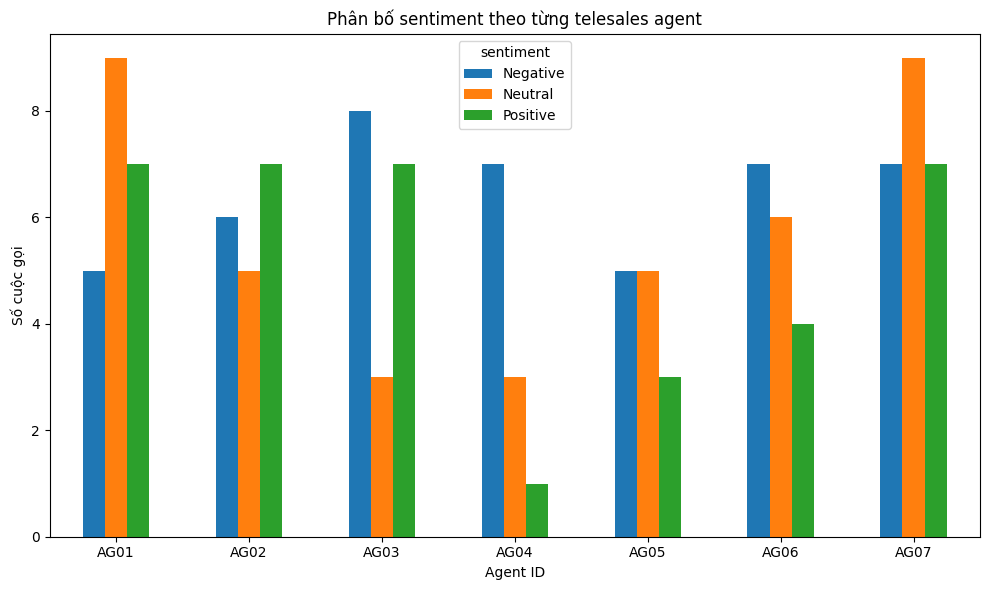

In [17]:
sentiment_pivot = (
    df.pivot_table(
        index="agent_id",
        columns="sentiment",
        values="call_id",
        aggfunc="count",
        fill_value=0
    )
)

print("📊 Số lượng cuộc gọi theo sentiment & agent:")
display(sentiment_pivot)

# Vẽ stacked bar
sentiment_pivot.plot(kind="bar", figsize=(10,6))
plt.title("Phân bố sentiment theo từng telesales agent")
plt.xlabel("Agent ID")
plt.ylabel("Số cuộc gọi")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


📊 Phân bố kết quả cuộc gọi:


,count
call_result,
Registered Product,45
No Answer,45
Busy,43
Connected - Not Interested,43
Wrong Number,37
Call Back Later,37
Connected - Interested,33


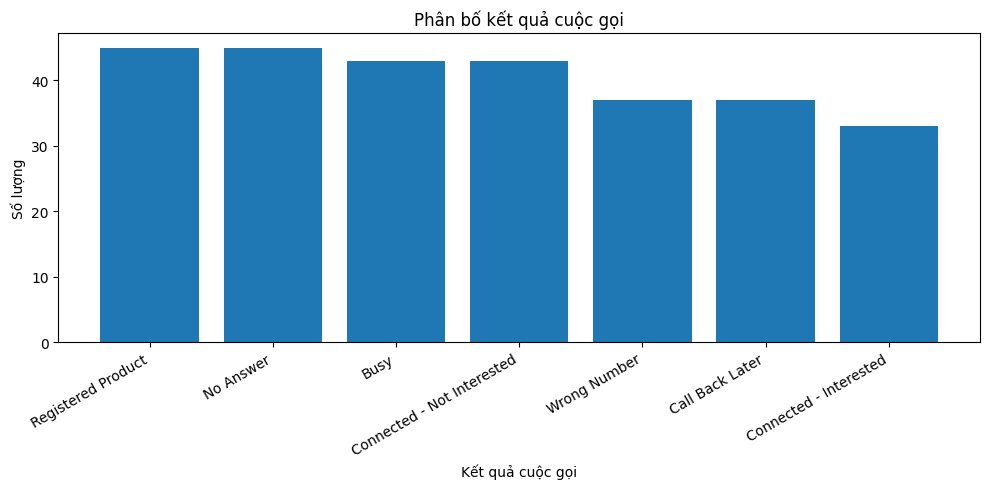

In [18]:
result_counts = df["call_result"].value_counts()

print("📊 Phân bố kết quả cuộc gọi:")
display(result_counts)

plt.figure(figsize=(10,5))
plt.bar(result_counts.index, result_counts.values)
plt.title("Phân bố kết quả cuộc gọi")
plt.xlabel("Kết quả cuộc gọi")
plt.ylabel("Số lượng")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


In [19]:
# 1. Dataset khách hàng sau làm sạch
customers_clean_path = "eximbank_customers_clean.csv"
customers.to_csv(customers_clean_path, index=False)
print(f"✅ Đã xuất: {customers_clean_path}")

# 2. Dataset cuộc gọi đã merge thông tin khách hàng
analysis_dataset_path = "eximbank_telesales_merged_analysis.csv"
df.to_csv(analysis_dataset_path, index=False)
print(f"✅ Đã xuất: {analysis_dataset_path}")

from google.colab import files
files.download(customers_clean_path)
files.download(analysis_dataset_path)


✅ Đã xuất: eximbank_customers_clean.csv
✅ Đã xuất: eximbank_telesales_merged_analysis.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>